In [49]:
import pandas as pd
df = pd.read_csv("./data/LPG_Random_Daily_Import_Volumes.csv", index_col='Date', parse_dates=["Date"])

print(df.head())
print(df.tail())

            Daily LPG Imports  LPG Imports(Modified)
Date                                                
2013-01-01        235855.3992            245855.3992
2013-01-02        328297.0447            338297.0447
2013-01-03        105912.6932            115912.6932
2013-01-04        266742.4569            276742.4569
2013-01-05        215043.9965            225043.9965
            Daily LPG Imports  LPG Imports(Modified)
Date                                                
2024-12-27        96235.63142           106235.63140
2024-12-28       131274.08740           141274.08740
2024-12-29        73631.70854            83631.70854
2024-12-30       112245.43610           122245.43610
2024-12-31        95373.46040           105373.46040


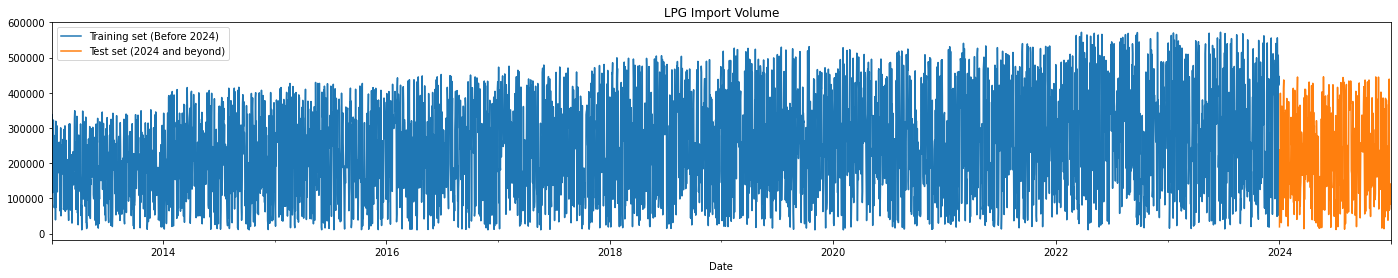

In [50]:
import matplotlib.pyplot as plt
# Plot the training set
df["LPG Imports(Modified)"][:'2023'].plot(figsize=(24, 4), legend=True)
# Plot the test set
df["LPG Imports(Modified)"]['2024':].plot(figsize=(24, 4), legend=True)
plt.legend(['Training set (Before 2024)', 'Test set (2024 and beyond)'])
plt.title('LPG Import Volume')
plt.show()

In [51]:
from sklearn.preprocessing import MinMaxScaler

# here we are seperating the data 
training_set = df[:'2023'].iloc[:,1:2].values
test_set = df['2024':].iloc[:,1:2].values

sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [52]:
import numpy as np

X_train = []
y_train = []

for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i - 60:i, 0])
    y_train.append(training_set_scaled[i, 0])
    
    
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def create_improved_model(input_shape):
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.2),
        
        LSTM(64, return_sequences=True),
        BatchNormalization(),
        Dropout(0.2),
        
        LSTM(32),
        BatchNormalization(),
        Dropout(0.2),
        
        Dense(16, activation='relu'),
        Dense(1)
    ])
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

In [54]:
model = create_improved_model((X_train.shape[1], 1))

c:\Users\saran\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [56]:
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

In [57]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[lr_scheduler],
    verbose=1
)

Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 0.4213 - val_loss: 0.2440 - learning_rate: 0.0010
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.1405 - val_loss: 0.1443 - learning_rate: 0.0010
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.0999 - val_loss: 0.1089 - learning_rate: 0.0010
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.0904 - val_loss: 0.1128 - learning_rate: 0.0010
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.0791 - val_loss: 0.0824 - learning_rate: 0.0010
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.0746 - val_loss: 0.0856 - learning_rate: 0.0010
Epoch 7/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.0738 - val_loss: 0.0865 - learning_rate: 0.0010
Epoch 8/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.0679 - val_loss: 0.0891 - learning_rate: 0.0010
Epoch 9/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.0673 - val_loss: 0.0927 - learning_rate: 0.0010
Epoch 10/

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


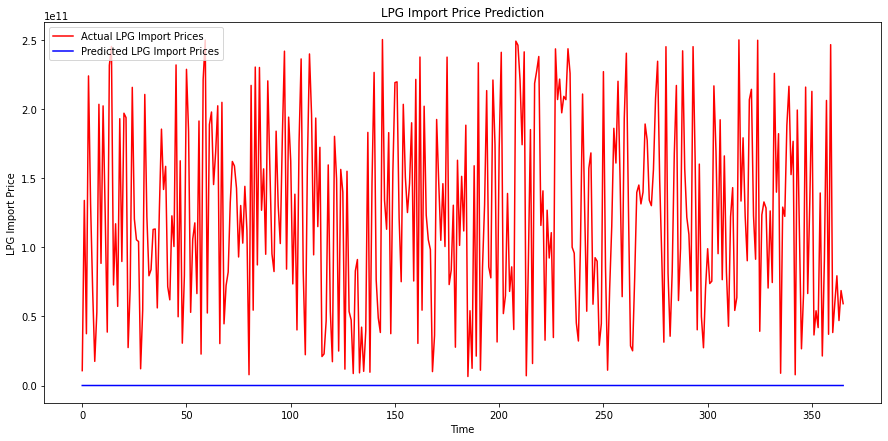

Mean Squared Error: 1.9982909130607757e+22
Root Mean Squared Error: 141360917974.5511
Mean Absolute Error: 123162115946.90886


In [48]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model

# Assuming df, test_set, and sc (MinMaxScaler) are already defined

# Pre-processing the data
def preprocess_data(df, test_set, scaler, lookback=60):
    # Concatenate training and test data
    dataset_total = pd.concat((df["LPG Imports(Modified)"][:'2023'], df["LPG Imports(Modified)"]['2024':]), axis=0)
    
    # Create inputs for the model
    inputs = dataset_total[len(dataset_total) - len(test_set) - lookback:].values
    inputs = inputs.reshape(-1, 1)
    inputs = scaler.transform(inputs)
    
    # Create X_test
    X_test = []
    for i in range(lookback, len(inputs)):
        X_test.append(inputs[i-lookback:i, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    return X_test

# Function to make predictions
def make_predictions(model, X_test, scaler):
    predicted_prices = model.predict(X_test)
    predicted_prices = scaler.inverse_transform(predicted_prices)
    return predicted_prices

# Load the trained model
# model = load_model('path_to_your_saved_model.h5')

# Preprocess the data
X_test = preprocess_data(df, test_set, sc)

# Make predictions
predicted_prices = make_predictions(model, X_test, sc)

# If you want to compare with actual test data
actual_prices = sc.inverse_transform(test_set)

# Plotting the results
import matplotlib.pyplot as plt

plt.figure(figsize=(15,7))
plt.plot(actual_prices, color='red', label='Actual LPG Import Prices')
plt.plot(predicted_prices, color='blue', label='Predicted LPG Import Prices')
plt.title('LPG Import Price Prediction')
plt.xlabel('Time')
plt.ylabel('LPG Import Price')
plt.legend()
plt.show()

# Evaluate the model
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

mse = mean_squared_error(actual_prices, predicted_prices)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_prices, predicted_prices)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")

In [40]:
# pre-processing the data 
dataset_total = pd.concat((df["LPG Imports(Modified)"][:'2023'],df["LPG Imports(Modified)"]['2024':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

# making the test data
X_test = []
for i in range(60,len(inputs)):
  X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


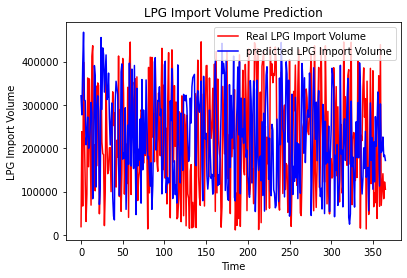

In [41]:
def plot_prediction(test,prediction):
    plt.plot(test,color='red',label="Real LPG Import Volume")
    plt.plot(prediction, color="blue",label="predicted LPG Import Volume")
    plt.title("LPG Import Volume Prediction")
    plt.xlabel("Time")
    plt.ylabel("LPG Import Volume")
    plt.legend()
    plt.show()
# now we'll use this function to visualize our test and predicted data

plot_prediction(test_set,predicted_stock_price)

In [42]:

import math
from sklearn.metrics import mean_squared_error

def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
  
return_rmse(test_set, predicted_stock_price)

The root mean squared error is 165645.86989662188.
